# Titanic

In [2]:
%matplotlib inline

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

##Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier

### Loading data

In [211]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
trainId=train["PassengerId"]
testId=test["PassengerId"]
df =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [212]:
df.tail()

Age Cabin Embarked      Fare                          Name  Parch  \
1304   NaN   NaN        S    8.0500            Spector, Mr. Woolf      0   
1305  39.0  C105        C  108.9000  Oliva y Ocana, Dona. Fermina      0   
1306  38.5   NaN        S    7.2500  Saether, Mr. Simon Sivertsen      0   
1307   NaN   NaN        S    8.0500           Ware, Mr. Frederick      0   
1308   NaN   NaN        C   22.3583      Peter, Master. Michael J      1   

      PassengerId  Pclass     Sex  SibSp  Survived              Ticket  
1304         1305       3    male      0       NaN           A.5. 3236  
1305         1306       1  female      0       NaN            PC 17758  
1306         1307       3    male      0       NaN  SOTON/O.Q. 3101262  
1307         1308       3    male      0       NaN              359309  
1308         1309       3    male      1       NaN                2668

In [213]:
def find_deck(cabin):
    try:
        match=re.search(r'[A-Z]',str(cabin))
        return match.group()
    except AttributeError:
        return 0

In [214]:
def survivors_ticket(index):
    ticketnr=df.loc[index,"Ticket"]
    temp=df[df["Ticket"]==ticketnr]
    if index<=890:
        survived=temp["Survived"].sum()-df.loc[index,"Survived"]
    else:
        survived=temp["Survived"].sum()
    if survived == 0:
        return 0
    if survived >0:
        return 1

In [215]:
def find_title(name):
    match=re.search(r",\s[A-Za-z]+",str(name))
    return match.group()[2:]

In [216]:
def family_size(size):
    if size==0:
        return "Single"
    if (size>=1) & (size<=3):
        return "Small"
    if size>=4:
        return "Large"

In [217]:
df["Deck"]=df["Cabin"].apply(find_deck)    
df["Sex"]=df["Sex"].map({"male":1,"female":0,1:1,0:0}).values
df["AgeGroup"]=pd.cut(df["Age"],range(0,81,10),right=True)
df["FareGroup"]=pd.cut(df["Fare"],range(0,301,25),right=False)
df["SurvivorsTicket"]=pd.Series(df.index).apply(survivors_ticket)
df["DeckKnown"]=df["Deck"].apply(lambda x: 1 if x else 0)
df["Title"]=df["Name"].apply(find_title)
df["Title"]=df["Title"].replace(["Capt","Col","Don","Dr","Jonkheer","Lady","Major",
                                 "Mlle","Mme","Ms","Rev","Sir","the","Dona"],"rare")
df["Size"]=df["SibSp"]+df["Parch"]
df["FSize"]=df["Size"].apply(family_size)

In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 20 columns):
Age                1046 non-null float64
Cabin              295 non-null object
Embarked           1307 non-null object
Fare               1308 non-null float64
Name               1309 non-null object
Parch              1309 non-null int64
PassengerId        1309 non-null int64
Pclass             1309 non-null int64
Sex                1309 non-null int64
SibSp              1309 non-null int64
Survived           891 non-null float64
Ticket             1309 non-null object
Deck               1309 non-null object
AgeGroup           1046 non-null category
FareGroup          1304 non-null category
SurvivorsTicket    1309 non-null int64
DeckKnown          1309 non-null int64
Title              1309 non-null object
Size               1309 non-null int64
FSize              1309 non-null object
dtypes: category(2), float64(3), int64(8), object(7)
memory usage: 151.2+ KB


In [219]:
df.describe()

Age         Fare        Parch  PassengerId       Pclass  \
count  1046.000000  1308.000000  1309.000000  1309.000000  1309.000000   
mean     29.881138    33.295479     0.385027   655.000000     2.294882   
std      14.413493    51.758668     0.865560   378.020061     0.837836   
min       0.170000     0.000000     0.000000     1.000000     1.000000   
25%      21.000000     7.895800     0.000000   328.000000     2.000000   
50%      28.000000    14.454200     0.000000   655.000000     3.000000   
75%      39.000000    31.275000     0.000000   982.000000     3.000000   
max      80.000000   512.329200     9.000000  1309.000000     3.000000   

               Sex        SibSp    Survived  SurvivorsTicket    DeckKnown  \
count  1309.000000  1309.000000  891.000000      1309.000000  1309.000000   
mean      0.644003     0.498854    0.383838         0.224599     0.225363   
std       0.478997     1.041658    0.486592         0.417477     0.417981   
min       0.000000     0.000000    0.000000         0.000000     0.000000   
25%       0.000000     0.000000    0.000000         0.000000     0.000000   
50%       1.000000     0.000000    0.000000         0.000000     0.000000   
75%       1.000000     1.000000    1.000000         0.000000     0.000000   
max       1.000000     8.000000    1.000000         1.000000     1.000000   

              Size  
count  1309.000000  
mean      0.883881  
std       1.583639  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max      10.000000

In [220]:
df.groupby("Embarked").size()

Embarked
C    270
Q    123
S    914
dtype: int64

In [221]:
df["Embarked"]=df["Embarked"].fillna(df["Embarked"].mode()[0])

In [222]:
df["Fare"]=df["Fare"].fillna(df["Fare"].median())

### Filling missing values age

Text(0.5,1,'Not Survived')

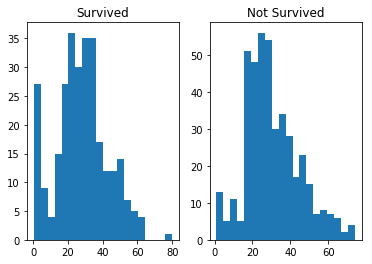

In [223]:
plt.subplot(1,2,1)
plt.hist(df["Age"][(df["Age"].notnull())&(df["Survived"]==1)],bins=20)
plt.title("Survived")

plt.subplot(1,2,2)
plt.hist(df["Age"][(df["Age"].notnull())&(df["Survived"]==0)],bins=20)
plt.title("Not Survived")

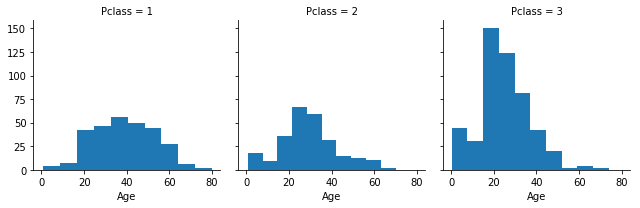

In [224]:
g=sns.FacetGrid(df[df["Age"].notnull()],col="Pclass").map(plt.hist,"Age")

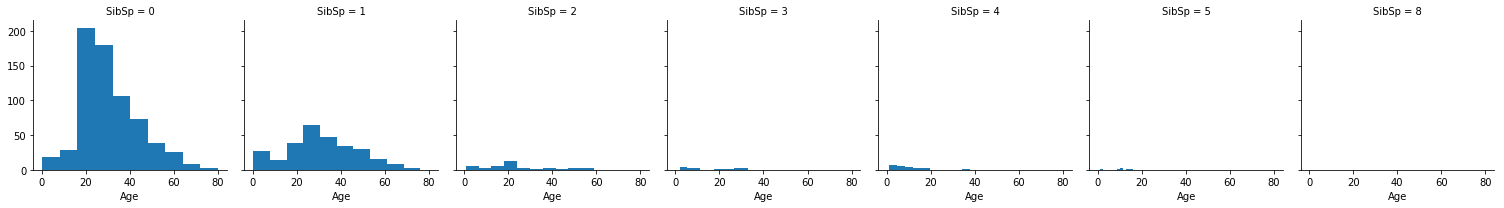

In [225]:
g=sns.FacetGrid(df[df["Age"].notnull()],col="SibSp").map(plt.hist,"Age")

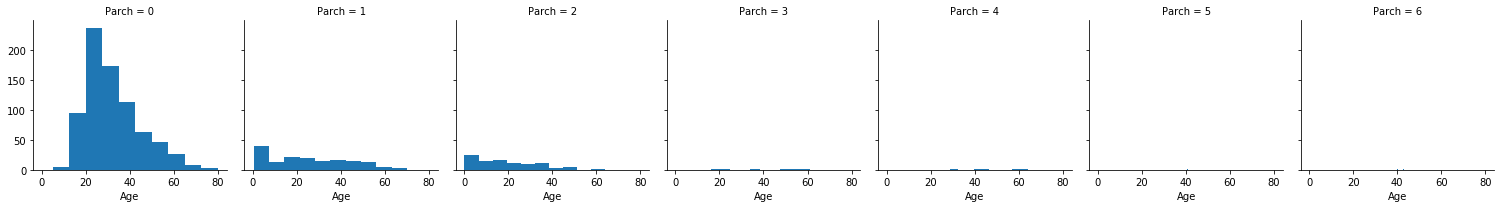

In [226]:
g=sns.FacetGrid(df[df["Age"].notnull()],col="Parch").map(plt.hist,"Age")

In [227]:
index_age=df[df["Age"].isnull()].index.values
median=df["Age"][df["Age"].notnull()].median()
for i in index_age: 
    Pclass,Parch,SibSp=df.loc[i,"Pclass"],df.loc[i,"Parch"],df.loc[i,"SibSp"]
    subset=df["Age"][(df["Pclass"]==Pclass)&(df["Parch"]==Parch)&(df["SibSp"]==SibSp)]
    if subset.any():
        median_s=int(subset.median())
        df.loc[i,"Age"]=median_s
    else:
        df.loc[i,"Age"]=median   

In [228]:
df.head()

Age Cabin Embarked     Fare  \
0  22.0   NaN        S   7.2500   
1  38.0   C85        C  71.2833   
2  26.0   NaN        S   7.9250   
3  35.0  C123        S  53.1000   
4  35.0   NaN        S   8.0500   

                                                Name  Parch  PassengerId  \
0                            Braund, Mr. Owen Harris      0            1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...      0            2   
2                             Heikkinen, Miss. Laina      0            3   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)      0            4   
4                           Allen, Mr. William Henry      0            5   

   Pclass  Sex  SibSp  Survived            Ticket Deck  AgeGroup FareGroup  \
0       3    1      1       0.0         A/5 21171    0  (20, 30]   [0, 25)   
1       1    0      1       1.0          PC 17599    C  (30, 40]  [50, 75)   
2       3    0      0       1.0  STON/O2. 3101282    0  (20, 30]   [0, 25)   
3       1    0      1       1.0            113803    C  (30, 40]  [50, 75)   
4       3    1      0       0.0            373450    0  (30, 40]   [0, 25)   

   SurvivorsTicket  DeckKnown Title  Size   FSize  
0                0          0    Mr     1   Small  
1                0          1   Mrs     1   Small  
2                0          0  Miss     0  Single  
3                0          1   Mrs     1   Small  
4                0          0    Mr     0  Single

In [229]:
df.corr()

Age      Fare     Parch  PassengerId    Pclass  \
Age              1.000000  0.193293 -0.144382     0.023265 -0.448152   
Fare             0.193293  1.000000  0.221635     0.031128 -0.558683   
Parch           -0.144382  0.221635  1.000000     0.008942  0.018322   
PassengerId      0.023265  0.031128  0.008942     1.000000 -0.038354   
Pclass          -0.448152 -0.558683  0.018322    -0.038354  1.000000   
Sex              0.057987 -0.185681 -0.213125     0.013406  0.124617   
SibSp           -0.247373  0.160349  0.373587    -0.055224  0.060832   
Survived        -0.041285  0.257307  0.081629    -0.005007 -0.338481   
SurvivorsTicket  0.018889  0.460932  0.278859     0.010784 -0.333753   
DeckKnown        0.311078  0.507321  0.036806    -0.000208 -0.713857   
Size            -0.241627  0.226609  0.792296    -0.031437  0.050027   

                      Sex     SibSp  Survived  SurvivorsTicket  DeckKnown  \
Age              0.057987 -0.247373 -0.041285         0.018889   0.311078   
Fare            -0.185681  0.160349  0.257307         0.460932   0.507321   
Parch           -0.213125  0.373587  0.081629         0.278859   0.036806   
PassengerId      0.013406 -0.055224 -0.005007         0.010784  -0.000208   
Pclass           0.124617  0.060832 -0.338481        -0.333753  -0.713857   
Sex              1.000000 -0.109609 -0.543351        -0.211564  -0.137396   
SibSp           -0.109609  1.000000 -0.035322         0.134205  -0.009064   
Survived        -0.543351 -0.035322  1.000000         0.382875   0.316912   
SurvivorsTicket -0.211564  0.134205  0.382875         1.000000   0.314329   
DeckKnown       -0.137396 -0.009064  0.316912         0.314329   1.000000   
Size            -0.188583  0.861952  0.016639         0.240689   0.014155   

                     Size  
Age             -0.241627  
Fare             0.226609  
Parch            0.792296  
PassengerId     -0.031437  
Pclass           0.050027  
Sex             -0.188583  
SibSp            0.861952  
Survived         0.016639  
SurvivorsTicket  0.240689  
DeckKnown        0.014155  
Size             1.000000

### Exploratory visualisation

In [230]:
features=["Sex","Pclass","FareGroup","Deck","SibSp","Parch","Embarked","SurvivorsTicket",\
          "DeckKnown","Title","FSize"]

In [231]:
d={}
for f in features:
    temp=df.groupby(["Survived",f]).size()
    d[f]=pd.concat([temp[0],temp[1]],axis=1).fillna(0)

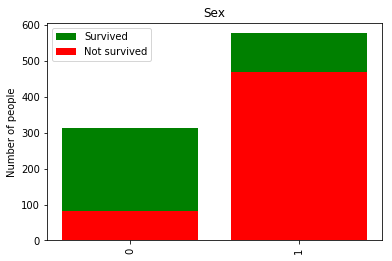

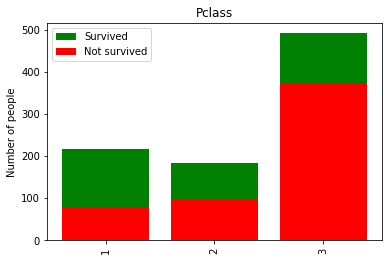

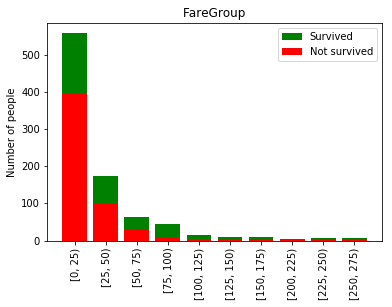

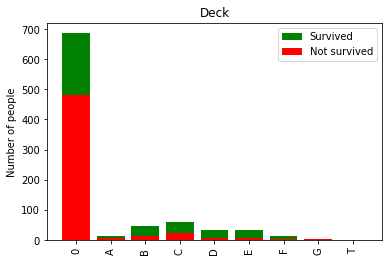

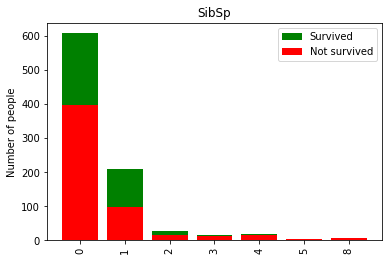

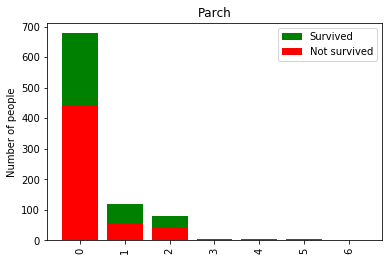

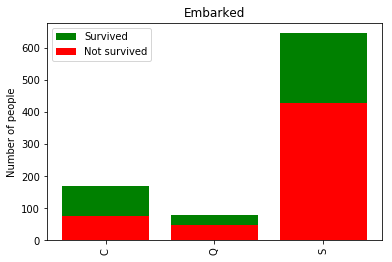

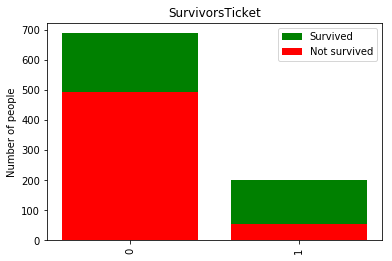

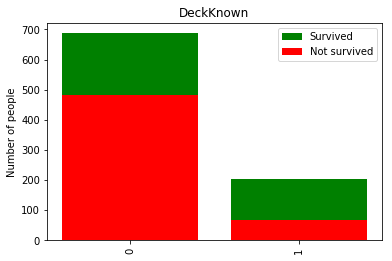

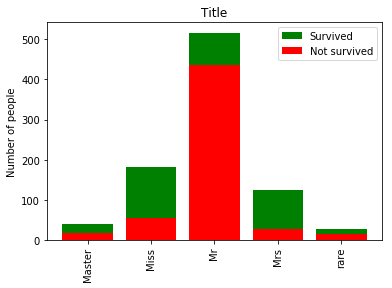

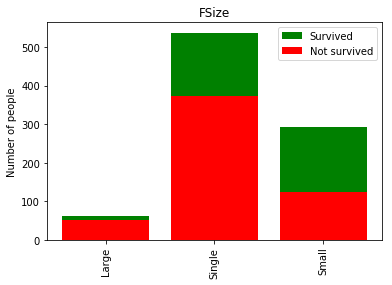

In [232]:
for f in features:
    plt.bar(np.arange(len(d[f][1])),d[f][1],bottom=d[f][0],label="Survived",color="g")
    plt.bar(np.arange(len(d[f][0])),d[f][0],label="Not survived",color="r")
    plt.xticks(np.arange(len(d[f][0])),d[f].index.values,rotation=90)
    plt.ylabel("Number of people")
    plt.title(f)
    plt.legend()
    plt.show()
    

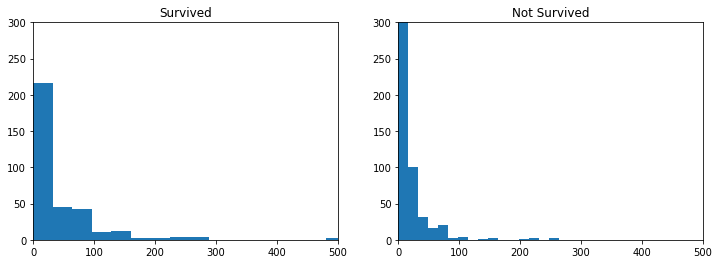

In [233]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(df["Fare"][(df["Survived"]==1)],bins=16)
plt.title("Survived")
plt.axis([0,500,0,300])

plt.subplot(1,2,2)
plt.hist(df["Fare"][(df["Survived"]==0)],bins=16)
plt.title("Not Survived")
plt.axis([0,500,0,300])
plt.show()

### Drop features and get dummies

In [236]:
df.drop(labels=["Name","PassengerId","Ticket","Cabin","FareGroup","AgeGroup","Deck",\
               "SibSp","Parch"],axis=1,inplace=True)

In [238]:
df=pd.get_dummies(df,columns=["Pclass","Embarked","FSize","Title"])

In [239]:
df.head()

Age     Fare  Sex  Survived  SurvivorsTicket  DeckKnown  Size  Pclass_1  \
0  22.0   7.2500    1       0.0                0          0     1         0   
1  38.0  71.2833    0       1.0                0          1     1         1   
2  26.0   7.9250    0       1.0                0          0     0         0   
3  35.0  53.1000    0       1.0                0          1     1         1   
4  35.0   8.0500    1       0.0                0          0     0         0   

   Pclass_2  Pclass_3     ...      Embarked_Q  Embarked_S  FSize_Large  \
0         0         1     ...               0           1            0   
1         0         0     ...               0           0            0   
2         0         1     ...               0           1            0   
3         0         0     ...               0           1            0   
4         0         1     ...               0           1            0   

   FSize_Single  FSize_Small  Title_Master  Title_Miss  Title_Mr  Title_Mrs  \
0             0            1             0           0         1          0   
1             0            1             0           0         0          1   
2             1            0             0           1         0          0   
3             0            1             0           0         0          1   
4             1            0             0           0         1          0   

   Title_rare  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 21 columns]

### Machine learning

In [240]:
X_full=df.drop(labels=["Survived"],axis=1)[:len(train)]
y_full=df["Survived"][:len(train)]
test=df.drop(labels=["Survived"],axis=1)[len(train):]

In [243]:
kfold=StratifiedKFold(n_splits=10)

In [244]:
tree=DecisionTreeClassifier()
svm=SVC()
adaboost=AdaBoostClassifier()
rf=RandomForestClassifier()
neigh=KNeighborsClassifier()
nb=GaussianNB()
xgb=XGBClassifier()
logr=LogisticRegression()

In [245]:
classifiers=[tree,svm,adaboost,rf,neigh,nb,xgb,logr]

In [246]:
outcomes={}
names=[]
mean_accuracy=[]
std=[]
for c in classifiers:
    outcomes[c]=cross_val_score(c,X_full,y_full,cv=kfold,scoring="accuracy",verbose=1)
    names.append(c.__class__.__name__)
    mean_accuracy.append(outcomes[c].mean())
    std.append(outcomes[c].std())
    

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [247]:
clf_results=pd.DataFrame({"Classifier":names,"Mean accuracy":mean_accuracy,"Standard Deviation":std})

In [248]:
clf_results

Classifier  Mean accuracy  Standard Deviation
0  DecisionTreeClassifier       0.800245            0.046570
1                     SVC       0.747674            0.040626
2      AdaBoostClassifier       0.825015            0.026011
3  RandomForestClassifier       0.823817            0.035107
4    KNeighborsClassifier       0.729671            0.033110
5              GaussianNB       0.802579            0.028428
6           XGBClassifier       0.845140            0.040647
7      LogisticRegression       0.833967            0.029226

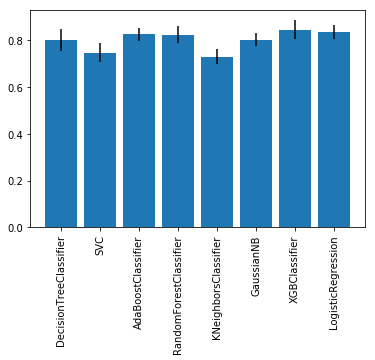

In [249]:
plt.bar(np.arange(len(clf_results)),clf_results["Mean accuracy"],yerr=clf_results["Standard Deviation"])
plt.xticks(np.arange(len(clf_results)),clf_results["Classifier"],rotation=90)
plt.show()

### Parameter tuning

In [250]:
tuning_results={}

In [251]:
def do_tune(clf_single,parameters,name):
    clf=GridSearchCV(clf_single,parameters,cv=kfold,scoring="accuracy",verbose=1,n_jobs=-1)
    clf.fit(X_full,y_full)
    tuning_results[name]=[clf.best_score_,clf.best_params_,clf.best_estimator_]
    return

In [252]:
parameters_AB={"learning_rate":[0.1,0.2,0.4,1],"n_estimators":[50],"base_estimator":[DecisionTreeClassifier()],"algorithm":\
              ["SAMME","SAMME.R"]}
parameters_RF = {"max_depth": [None],"max_features": [1, 3, 10],"min_samples_split": [2, 3, 10],"min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],"n_estimators" :[100,300],"criterion": ["gini"]}
parameters_logr={"C":[0.001,0.01,0.1,1,10,100,1000]}
parameters_xgb={"max_depth":[3,5,7,9,11,13,17,20],"learning_rate":[0.01,0.1]}


In [253]:
do_tune(adaboost,parameters_AB,"adaboost")
do_tune(rf,parameters_RF,"rf")
do_tune(logr,parameters_logr,"logr")
do_tune(xgb,parameters_xgb,"xgb")

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   21.3s finished


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  2.2min finished


Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  55 out of  70 | elapsed:   27.5s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   27.5s finished


Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   12.8s finished


In [254]:
results,keys,clf_best=[],[],[]
for k in tuning_results.keys():
    keys.append(k)
    results.append(tuning_results[k][0])   
    clf_best.append(tuning_results[k][2])

In [255]:
pd.DataFrame({"name":keys,"tuned accuracy":results})

name  tuned accuracy
0       xgb        0.845118
1        rf        0.840629
2      logr        0.833895
3  adaboost        0.818182

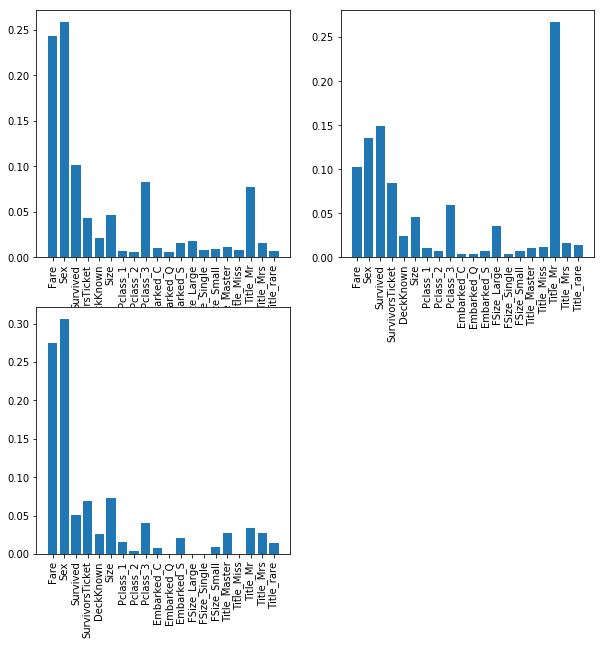

In [256]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.bar(np.arange(len(df.columns)-1),tuning_results["adaboost"][2].feature_importances_)
plt.xticks(np.arange(len(df.columns)-1),df.columns[1:],rotation=90)
plt.subplot(2,2,2)
plt.bar(np.arange(len(df.columns)-1),tuning_results["rf"][2].feature_importances_)
plt.xticks(np.arange(len(df.columns)-1),df.columns[1:],rotation=90)
plt.subplot(2,2,3)
plt.bar(np.arange(len(df.columns)-1),tuning_results["xgb"][2].feature_importances_)
plt.xticks(np.arange(len(df.columns)-1),df.columns[1:],rotation=90)
plt.show()

In [169]:
clf_best

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
        max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
        n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=True, subsample=1),
 RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
             max_depth=None, max_features=10, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=3, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', 

In [261]:
pred_xgb=clf_best[0].predict(test)
pred_rf=clf_best[1].predict(test)
pred_logr=clf_best[2].predict(test)
pred_ab=clf_best[3].predict(test)

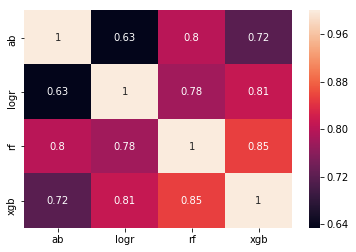

In [265]:
sns.heatmap(pd.DataFrame({"xgb":pred_xgb,"rf":pred_rf,"logr":pred_logr,"ab":pred_ab}).corr(),annot=True)

### Output

In [292]:
submission=pd.concat([testId,pd.Series(pred_xgb).astype(int)],axis=1)

In [293]:
submission.columns=["PassengerId","Survived"]

In [294]:
submission.to_csv("SecondSubmission.csv",index=False)